In [1]:
import numpy as np  
import pandas as pd 
import os


data = []

for dirpath, dirnames, filenames in os.walk('data\\'):
    for filename in filenames:
        data.append(os.path.join('data', filename))


gender_submission_path, test_path, train_path = data

train = pd.read_csv(train_path)

test = pd.read_csv(test_path)


In [2]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Data check
Both test and train contain missing values 

In [3]:
train.isnull().sum()
'''
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
'''
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Taking care of lost or wrong data

As of right now im only filling age columns with its median, ignoring cabin column

In [4]:
from sklearn.impute import SimpleImputer

def fill_nas(df):
    median = df['Age'].median()
    return df['Age'].fillna(median)

In [5]:
train['Age'] = fill_nas(train)
test['Age'] = fill_nas(test)

#### Feature engineering

In [6]:
def feature_engineering(df):
    df['FamSize'] = df['SibSp'] + df['Parch']
    df['IsAlone'] = (df['FamSize'] >= 1).astype(int)
    df['FarePerPerson'] = np.where(df['FamSize'] > 1, df['Fare']/df['FamSize'],  df['Fare'])
    df['NameLength'] = df['Name'].apply(len)

In [7]:
feature_engineering(train)
feature_engineering(test)

#### Encoding

In [8]:
def encode(df):
    return pd.get_dummies(df, columns=['Sex', 'Embarked'], dtype=int)

In [9]:
train = encode(train)
test = encode(test)

#### Choosing features

In [10]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamSize', 'IsAlone', 'FarePerPerson',
            'NameLength', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [11]:
X = train[features]
y = train['Survived']

X

,Pclass,Age,SibSp,Parch,Fare,FamSize,IsAlone,FarePerPerson,NameLength,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,1,7.250000,23,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,1,71.283300,51,1,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,7.925000,22,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,53.100000,44,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,0,8.050000,24,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,13.000000,21,0,1,0,0,1
887,1,19.0,0,0,30.0000,0,0,30.000000,28,1,0,0,0,1
888,3,28.0,1,2,23.4500,3,1,7.816667,40,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,0,30.000000,21,0,1,1,0,0


In [12]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

#### Model choosing and validation
#### Fine tuning CVsearch



In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

params = {
    'min_child_weight': [1, 3, 5],
    'gamma': [0.1, 0.5, 1, 1.5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.02, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 500]
}

for i in range(10):
    titanic_model = XGBClassifier(random_state=1, device='cuda')

    grid_search = RandomizedSearchCV(estimator=titanic_model, param_distributions=params, cv=5, scoring='accuracy', n_jobs=6)

    #%time 
    grid_search.fit(train_X, train_y)

    print(f'Best accuracy score:{grid_search.best_score_}')
    print(f'Best params:{grid_search.best_params_}')
    print('----------------------------------')


Best accuracy score:0.8338570306362921
Best params:{'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 0.7}
----------------------------------
Best accuracy score:0.8323757154079228
Best params:{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 0.1, 'colsample_bytree': 0.5}
----------------------------------
Best accuracy score:0.8413533834586466
Best params:{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.1, 'colsample_bytree': 0.5}
----------------------------------
Best accuracy score:0.8263718998990012
Best params:{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.7}
----------------------------------
Best accuracy score:0.8308607339243632
Best params:{'subsample': 0.9, 'n_estimators': 200, 'min

In [70]:
params = {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.1, 'colsample_bytree': 0.5}

titanic_model = XGBClassifier(**params, random_state=1, device='cuda')

titanic_model.fit(train_X, train_y)

prediction_for_val = titanic_model.predict(val_X)

cv_score = cross_val_score(titanic_model, train_X, train_y, cv=5)
titanic_val_accuracy_score = accuracy_score(y_pred=prediction_for_val, y_true=val_y)
titanic_val_confusion_matrix = confusion_matrix(y_pred=prediction_for_val, y_true=val_y)

print(f'Accuracy for random forest classifier:\n {titanic_val_accuracy_score}')
print(f'Confusion Matrix for random forest classifier:\n {titanic_val_confusion_matrix}')
print(f'CV score for random forest classifier:\n {cv_score.mean()}')

Accuracy for random forest classifier:
 0.7892376681614349
Confusion Matrix for random forest classifier:
 [[118  10]
 [ 37  58]]
CV score for random forest classifier:
 0.8413533834586466


#### Previous attempt

`titanic_model = RandomForestClassifier(max_depth=10, max_features=8, max_leaf_nodes=25, max_samples=500,` \
                                       `n_estimators=100, min_samples_split=2, min_samples_leaf=2, random_state=1)`\
Accuracy for random forest classifier:\
 0.7937219730941704\
Confusion Matrix for random forest classifier:\
 [[118  10]\
 [ 36  59]]\
CV score for random forest classifier:\
 [0.79104478 0.8358209  0.86567164 0.84962406 0.84210526]


### Feature importance

C:\Users\damia\AppData\Local\Temp\ipykernel_14168\866461988.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Contribution', data=feature_importance, palette='husl')


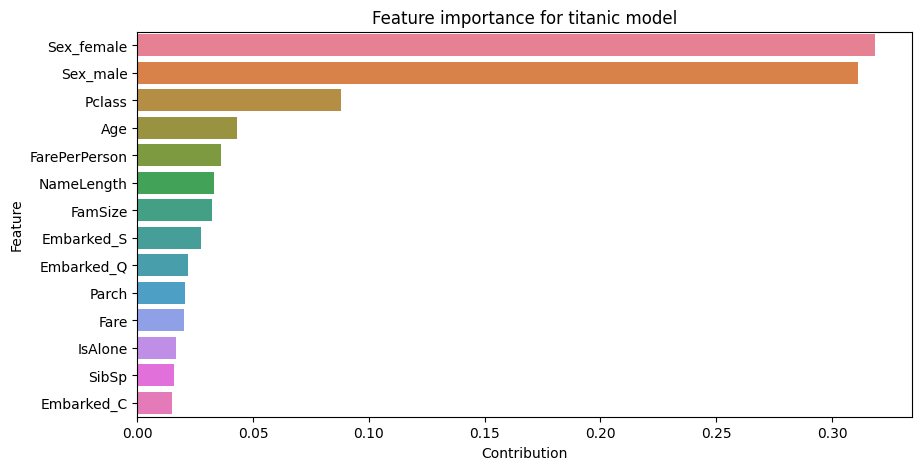

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({'Feature':features, 'Contribution':titanic_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Contribution', ascending=False)


plt.figure(figsize=(10, 5))
plt.title('Feature importance for titanic model')

sns.barplot(y='Feature', x='Contribution', data=feature_importance, palette='husl')

plt.show()

#### Actual prediction

In [72]:
prediction = pd.DataFrame(test['PassengerId'])

features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamSize', 'IsAlone', 'FarePerPerson',
            'NameLength', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

test = test[features]

In [73]:
prediction['Survived'] = titanic_model.predict(test)

prediction

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### exporting results into a CSV file

In [74]:
def export_results(prediciton_df):
    
    data = []

    for dirpath, dirnames, filenames in os.walk('submissions\\'):
        for filename in filenames:
            data.append(filename.split('_')[1])
    
    files_numbers = [int(number.split('.')[0]) for number in data]
    
    new_sub_name = ''.join(['submissions\\submission_', str(max(files_numbers) + 1), '.csv'])

    prediciton_df.to_csv(path_or_buf=new_sub_name, columns=['PassengerId', 'Survived'], index=False)
    
    return new_sub_name

In [75]:
sub_list = export_results(prediction)

sub_list

'submissions\\submission_13.csv'

#### Comparing submissions

In [76]:
def get_sub_list():
    
    sub_list = []

    for dirpath, dirnames, filenames in os.walk('submissions\\'):
        for filename in filenames:
            sub_list.append(os.path.join('submissions\\', filename))
    
    return sub_list

In [77]:
get_sub_list()

['submissions\\submission_1.csv',
 'submissions\\submission_10.csv',
 'submissions\\submission_11.csv',
 'submissions\\submission_12.csv',
 'submissions\\submission_13.csv',
 'submissions\\submission_2.csv',
 'submissions\\submission_3.csv',
 'submissions\\submission_4.csv',
 'submissions\\submission_5.csv',
 'submissions\\submission_6.csv',
 'submissions\\submission_7.csv',
 'submissions\\submission_8.csv',
 'submissions\\submission_9.csv']

get a submission from the list above and use it in `compare_submissions` function

In [81]:
def comapre_submissions(sub_a, sub_b):
    sub_a = pd.read_csv(sub_a)
    sub_b = pd.read_csv(sub_b)
    
    different_predictions = 0
    
    for a, b in zip(sub_a['Survived'], sub_b['Survived']):
        if a != b: different_predictions += 1
        
    return different_predictions
    
    
comapre_submissions('submissions\\submission_2.csv', 'submissions\\submission_13.csv')

79